<a href="https://colab.research.google.com/github/DanielCalderon97/Proyecto_Final_Text_Minning_Image/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final
### Daniel Calderón - 24000152


### Problema 1 (Word Cloud con Tweets)

In [ ]:
# Montamos Google Drive
# Ruta al archivo en tu Google Drive

from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Colab Notebooks/ProyectoFinal/tw_source.csv.zip"


import os
assert os.path.exists(zip_path), f"No se encontró el archivo en: {zip_path}"
print("Archivo encontrado en Google Drive:", zip_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivo encontrado en Google Drive: /content/drive/MyDrive/Colab Notebooks/ProyectoFinal/tw_source.csv.zip


In [ ]:
# Instalamos dependencias
import sys, subprocess, pkgutil

def pip_install(pkgs):
    for p in pkgs:
        if pkgutil.find_loader(p.split("==")[0]) is None:
            subprocess.check_call([sys.executable, "-m", "pip", "install", p])

pip_install(["pandas","numpy","nltk","spacy","wordcloud","tqdm"])

# spaCy EN
try:
    import spacy
    spacy.load("en_core_web_sm")
except Exception:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])

# Recursos NLTK
import nltk
for r in ["stopwords","punkt","wordnet","omw-1.4"]:
    try:
        nltk.data.find(f"corpora/{r}")
    except LookupError:
        nltk.download(r)

print("Dependencias listas")


/tmp/ipython-input-458771436.py:6: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader(p.split("==")[0]) is None:


Dependencias listas


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Cargamos el CSV DENTRO del ZIP con chunks

import zipfile, pandas as pd

with zipfile.ZipFile(zip_path, 'r') as z:
    names = z.namelist()
    csv_candidates = [n for n in names if n.lower().endswith('.csv') and not n.startswith('__MACOSX/')]
    assert len(csv_candidates) >= 1, f"No encontré CSV válido: {names}"
    csv_name = csv_candidates[0]
    print("✅ CSV detectado:", csv_name)

def make_chunk_iter(chunksize=200_000):
    z = zipfile.ZipFile(zip_path, 'r')
    f = z.open(csv_name)
    return pd.read_csv(
        f, header=None,
        names=["target","id","date","flag","user","text"],
        chunksize=chunksize,
        encoding_errors="ignore"
    )

chunk_iter = make_chunk_iter()
first = next(chunk_iter)
print("Filas en primer chunk:", len(first))
first.head()



✅ CSV detectado: tw_source.csv
Filas en primer chunk: 200000


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Contar menciones en todo el dataset
import re
from collections import Counter
from tqdm import tqdm

mention_re = re.compile(r"@([A-Za-z0-9_]{1,15})")
mention_counts = Counter()

for txt in first["text"].astype(str):
    mention_counts.update(mention_re.findall(txt))

for chunk in tqdm(make_chunk_iter(), desc="Contando menciones"):
    for txt in chunk["text"].astype(str):
        mention_counts.update(mention_re.findall(txt))

top3_df = pd.DataFrame(mention_counts.most_common(3), columns=["usuario","menciones"])
display(top3_df)

top3 = [u for u,_ in mention_counts.most_common(3)]
print("Top3 usuarios:", top3)

# Nos damos cuenta que el top tres pertenece a Mileycyrus, tommcfly y ddlovato


Contando menciones: 8it [00:07,  1.14it/s]


,usuario,menciones
0,mileycyrus,4891
1,tommcfly,4269
2,ddlovato,3745


Top3 usuarios: ['mileycyrus', 'tommcfly', 'ddlovato']


In [ ]:
# Construcción de Corpus por usuario

def rows_for_user(user_handle, chunk):
    mask = chunk["text"].astype(str).str.contains(fr"@{re.escape(user_handle)}\b", regex=True)
    sub = chunk.loc[mask, ["id","date","text"]].copy()
    sub.rename(columns={"date":"timestamp"}, inplace=True)
    sub["length"] = sub["text"].astype(str).str.len()
    return sub

corpus_dict = {u: pd.DataFrame(columns=["id","timestamp","text","length"]) for u in top3}

for u in top3:
    corpus_dict[u] = pd.concat([corpus_dict[u], rows_for_user(u, first)], ignore_index=True)

for chunk in make_chunk_iter():
    for u in top3:
        corpus_dict[u] = pd.concat([corpus_dict[u], rows_for_user(u, chunk)], ignore_index=True)

for u in top3:
    print(f"@{u}: {len(corpus_dict[u])} tweets")
    display(corpus_dict[u].head(3))


@mileycyrus: 4872 tweets


,id,timestamp,text,length
0,1468063101,Mon Apr 06 23:30:57 PDT 2009,@mileycyrus hahaha dont be like that one time ...,107
1,1468286517,Tue Apr 07 00:45:20 PDT 2009,"@mileycyrus i have the same problem, but it's ...",137
2,1468297110,Tue Apr 07 00:49:07 PDT 2009,@mileycyrus I guess counting sheep didn't work...,72


@tommcfly: 4262 tweets


,id,timestamp,text,length
0,1468210813,Tue Apr 07 00:19:09 PDT 2009,@tommcfly hey saw u guys play @ pushover..didn...,138
1,1468233211,Tue Apr 07 00:26:52 PDT 2009,@tommcfly Good morning Tom! Why can't I send y...,131
2,1468391638,Tue Apr 07 01:23:07 PDT 2009,@tommcfly did you know that johnsons baby use ...,96


@ddlovato: 3729 tweets


,id,timestamp,text,length
0,1467929230,Mon Apr 06 22:51:34 PDT 2009,@ddlovato @David_Henrie ummmmm i cant find it.,47
1,1467953367,Mon Apr 06 22:58:30 PDT 2009,@ddlovato Do you hate us?? Please don't,40
2,1469661950,Tue Apr 07 07:02:58 PDT 2009,@ddlovato Wish that i could see it.. Thats th...,96


In [ ]:
# Normalización y contexto
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

stop_en = set(stopwords.words("english"))
stop_es = set(stopwords.words("spanish"))
stop_all = stop_en | stop_es

lemmatizer = WordNetLemmatizer()
stem_en = SnowballStemmer("english")
stem_es = SnowballStemmer("spanish")

import spacy
try:
    nlp_en = spacy.load("en_core_web_sm")
except: nlp_en = None
try:
    nlp_es = spacy.load("es_core_news_sm")
except: nlp_es = None

token_re_word = re.compile(r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+(?:'[A-Za-z]+)?")

def normalize_tokens(tokens):
    tokens = [t.lower() for t in tokens if t.lower() not in stop_all]
    lemmas = []
    for t in tokens:
        lemma = t
        if nlp_en:
            doc = nlp_en(t)
            if len(doc): lemma = doc[0].lemma_.lower()
        if lemma==t and nlp_es and re.search(r"[áéíóúñ]", t):
            doc2 = nlp_es(t)
            if len(doc2): lemma = doc2[0].lemma_.lower()
        lemmas.append(lemma)
    stems = []
    for t in lemmas:
        s = stem_en.stem(t)
        if re.search(r"[áéíóúñ]", t):
            s2 = stem_es.stem(t)
            s = min([s,s2], key=len)
        stems.append(s)
    return stems

def extract_context_window(text, user_handle, window=6):
    raw = re.findall(r"@?[A-Za-z0-9_]{1,15}|[A-Za-zÁÉÍÓÚÜÑáéíóúüñ']+", text)
    target = f"@{user_handle}"
    idxs = [i for i,t in enumerate(raw) if t.lower()==target.lower()]
    if not idxs: return []
    i = idxs[0]
    lo, hi = max(0,i-window), min(len(raw), i+window+1)
    window_tokens = [t for t in raw[lo:hi] if not t.startswith("@")]
    return [t for t in window_tokens if token_re_word.fullmatch(t)]


In [ ]:
# Frecuencias de contexto por usuario

# Parámetros ajustables (lo puse asi porque estaba demorando mucho antes)
WINDOW = 6   # tokens a izquierda y derecha de la mención
TOPN   = 10  # palabras más frecuentes para WordCloud y explicación


freq_tables = {}
for u, corpus in corpus_dict.items():
    from collections import Counter
    freq = Counter()
    for txt in corpus["text"].astype(str):
        ctx = extract_context_window(txt, u, window=WINDOW)
        if ctx:
            freq.update(normalize_tokens(ctx))
    freq_tables[u] = pd.DataFrame(freq.most_common(50), columns=["token","freq"])
    print(f"Top 20 @{u}")
    display(freq_tables[u].head(20))

Top 20 @mileycyrus


,token,freq
0,miley,630
1,http,515
2,com,504
3,twitpic,496
4,love,375
5,vote,298
6,u,256
7,go,194
8,good,190
9,come,186


Top 20 @tommcfly


,token,freq
0,tom,620
1,say,262
2,http,185
3,pleas,182
4,hey,167
5,u,163
6,good,160
7,come,160
8,love,156
9,com,153


Top 20 @ddlovato


,token,freq
0,demi,475
1,love,274
2,u,204
3,wish,191
4,go,179
5,http,176
6,twitpic,176
7,com,159
8,come,148
9,see,140


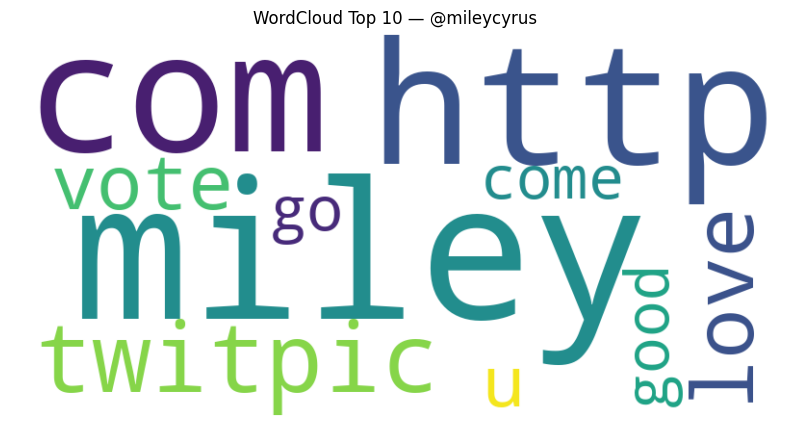

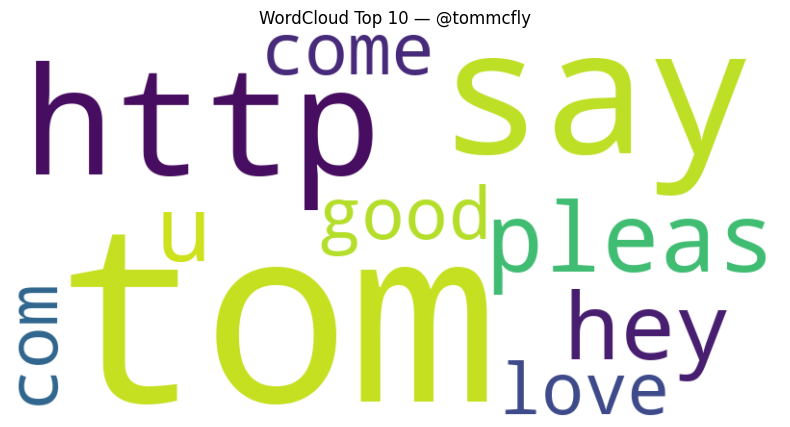

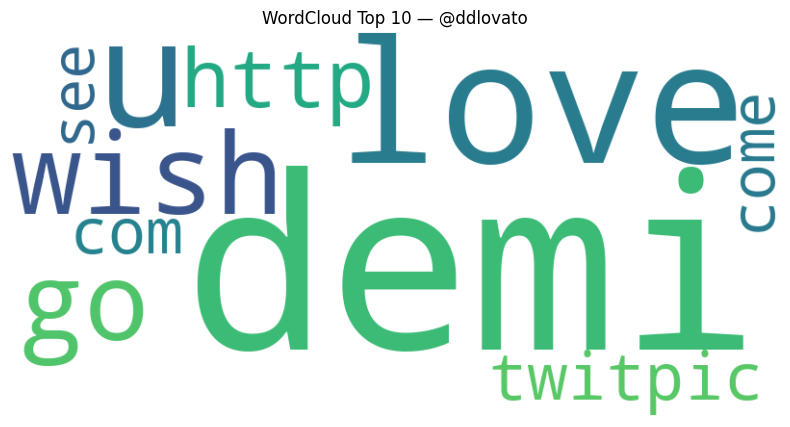

In [ ]:
# WordClouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud_for_user(user_handle, df_freq, topn=10):
    top = dict(df_freq.head(topn).values)
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(top)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud Top {topn} — @{user_handle}")
    plt.show()

for u, df in freq_tables.items():
    plot_wordcloud_for_user(u, df, topn=TOPN)


In [ ]:
# Explicacion
def explain_mentions(freq_df, user, topn=10):
    top_terms = [t for t,_ in freq_df.head(topn).values]
    return f"@{user} es citado por: {', '.join(top_terms[:5])}"

print("Resumen final:")
print("Top-3:", top3)
for u in top3:
    print(f"- @{u}: {len(corpus_dict[u])} tweets")
for u,df in freq_tables.items():
    print("—", explain_mentions(df,u,TOPN))


Resumen final:
Top-3: ['mileycyrus', 'tommcfly', 'ddlovato']
- @mileycyrus: 4872 tweets
- @tommcfly: 4262 tweets
- @ddlovato: 3729 tweets
— @mileycyrus es citado por: miley, http, com, twitpic, love
— @tommcfly es citado por: tom, say, http, pleas, hey
— @ddlovato es citado por: demi, love, u, wish, go
